In [11]:
from sentinelhub import SHConfig

config = SHConfig()
#create an client and instance on sentinal-hub
config.sh_client_id = '1543b9e6-3abf-441b-9f19-0c8b70b925b2'
config.sh_client_secret = 'J2H.z_4ENpdQomb)Q1t*f-u?Zh<{)TH1Cd4JmQMv'
config.instance_id = "d6043a1f-543a-453e-acd6-8f90b6b74f56"
config.save()
if not config.sh_client_id or not config.sh_client_secret:
    print("Warning! To use Process API, please provide the credentials (OAuth client ID and client secret).")
    
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from datetime import datetime
from dateutil.relativedelta import relativedelta
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sentinelhub import (
    CRS,
    BBox,
    Geometry,
    DataCollection,
    DownloadRequest,
    MimeType,
    MosaickingOrder,
    SentinelHubDownloadClient,
    SentinelHubRequest,
    bbox_to_dimensions,
)

# The following is not a package. It is a file utils.py which should be in the same folder as this notebook.
from utils import plot_image
from s2cloudless import CloudMaskRequest, S2PixelCloudDetector, get_s2_evalscript

#bounding box defining
def bbox_cord(poly):
    poly_arr = np.array(poly)
    df = pd.DataFrame(poly_arr, columns = ['long','lat'])
    Xmin = df['lat'].min()
    Ymin = df['long'].min()
    Xmax = df['lat'].max()
    Ymax = df['long'].max()
    bbox = [Xmin,Ymin,Xmax,Ymax]
    i = [1,0]
    output = poly_arr[:,i]
    output = output.tolist()
    return bbox,output



#date range
def date_range():
    current_date = datetime.today()
    past_date = datetime.today() - relativedelta(months=6)
    n_chunks = 6
    tdelta = (current_date - past_date) / n_chunks
    edges = [(past_date + i * tdelta).date().isoformat() for i in range(n_chunks+1)]
    slots = [(edges[i], edges[i + 1]) for i in range(len(edges) - 1)]
    return slots
    

evalscript_true_color = """
    //VERSION=3

    function setup() {
        return {
            input: [{
                bands: ["B02", "B03", "B04","B08","CLM"],
                
            }],
            output: {
                bands: 5,
                sampleType: "float32"
            }
        };
    }

    function evaluatePixel(sample) {
        return [sample.B02, sample.B03, sample.B04,sample.B08,sample.CLM];
    }
"""
#32 bit Tiff output wuth 4 bands
def request_all_bands(time_interval,final_bbox,geometry):
    
    return  SentinelHubRequest(
        data_folder="Data", #data store directory
        evalscript=evalscript_true_color,
        input_data=[
            SentinelHubRequest.input_data(
                data_collection=DataCollection.SENTINEL2_L2A,
                time_interval=time_interval,
                mosaicking_order=MosaickingOrder.LEAST_CC,
                #other_args={"dataFilter": {"maxCloudCoverage": 50}},
            )
        ],
        responses=[SentinelHubRequest.output_response("default", MimeType.TIFF)],
        bbox=final_bbox,
        size=box_size,
        geometry = geometry,
        config=config,
    )




# plotting
def plott(list_of_requests):
    
    #best=np.count_nonzero(cloud_pix == 1) #initializing
    ncols = 3
    nrows = 2
    aspect_ratio = box_size[0] / box_size[1]
    subplot_kw = {"xticks": [], "yticks": [], "frame_on": False}
    pos=0 #position
    best_slot=0
    #
    #fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(5 * ncols * aspect_ratio, 5 * nrows), subplot_kw=subplot_kw)
    cloud_pix=list_of_requests[0][0]
    best=np.count_nonzero(cloud_pix == 1)
    for  idx, image in enumerate(list_of_requests):
        cloud_pix = image[0][:, :, 4]
        cloud = np.count_nonzero(cloud_pix == 1)
        if best >= cloud :
            best=cloud
            best_slot=slots[idx]
            pos = idx
    return pos
    #print(idx,cloud,slots[idx],imagex.shape)
    #ax = axs[idx // ncols][idx % ncols]
    #ax.imshow(np.clip(imagex * 2.5 , 0, 1))
    #ax.set_title(f"{slots[idx][0]}  -  {slots[idx][1]}", fontsize=10)
#plt.tight_layout()






In [12]:
def senti_api (poly)
    #poly = [[7.090278,80.55444],[7.090278,80.55417],[7.090556,80.55222],[7.090278,80.55167],[7.09,80.55083],[7.091389,80.54806],[7.093056,80.55],[7.093333,80.55083],[7.094167,80.55306],[7.094167,80.55333],[7.093889,80.55417],[7.093611,80.555],[7.0925,80.55528],[7.091667,80.55528],[7.090833,80.555]]
    bbox_generated,poly = bbox_cord(poly)

    slots = date_range()

    #define diementions for the request
    final_bbox = BBox(bbox=bbox_generated, crs=CRS.WGS84)
    geometry = Geometry(geometry={"type":"Polygon","coordinates":[poly]}, crs=CRS.WGS84)

    #resolution and size of the output
    resolution =10
    box_size = bbox_to_dimensions(final_bbox, resolution= resolution)

    # create a list of requests
    list_of_requests = [request_all_bands(slot,final_bbox,geometry) for slot in slots]
    list_of_requests = [request.get_data() for request in list_of_requests]
    pos = plott(list_of_requests)
    img = list_of_requests[pos][0][:, :, [0, 1, 2]]
    return poly,resolution

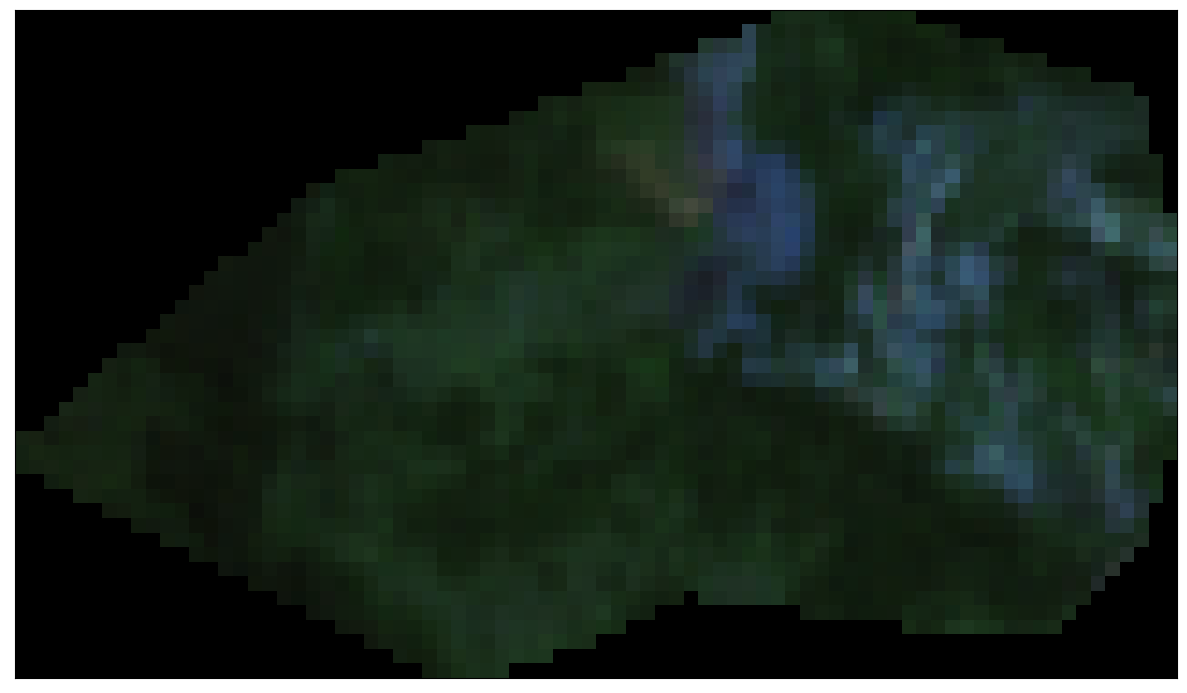

In [10]:
plot_image(list_of_requests[pos][0][:, :, [0, 1, 2]], factor=2.5, clip_range=(0, 1))